In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import pandas_profiling as pp
import plotly.graph_objects as go
%matplotlib inline

# preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_squared_error,accuracy_score, confusion_matrix, explained_variance_score

# Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import ipywidgets

import warnings
warnings.filterwarnings('ignore')




### EDA

In [7]:
df=pd.read_csv('heart_disease_uci.csv')
df.head(5)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [9]:
cv_n_split =5  #number of splitting iterations in the cross-validator
random_state =42
train_test_split_part =0.25

In [10]:
metrics_all ={1:'accuracy', 2:'rmse', 3:'re'}
metrics_now ={1,2,3}# we can  only select some numbers from metrics_all

In [11]:
df['target']=df['num']
df =df.drop(columns =['id','dataset','ca','thal','num'],axis=1)


In [12]:
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,2


In [13]:
df =df[(df['chol'] <=420) & (df['oldpeak'] >=0) & (df['oldpeak'] <=4)].reset_index(drop =True)
df =df.dropna().reset_index(drop =True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       520 non-null    int64  
 1   sex       520 non-null    object 
 2   cp        520 non-null    object 
 3   trestbps  520 non-null    float64
 4   chol      520 non-null    float64
 5   fbs       520 non-null    object 
 6   restecg   520 non-null    object 
 7   thalch    520 non-null    float64
 8   exang     520 non-null    object 
 9   oldpeak   520 non-null    float64
 10  slope     520 non-null    object 
 11  target    520 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 48.9+ KB


In [14]:
df.describe()

,age,trestbps,chol,thalch,oldpeak,target
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,54.780769,133.365385,215.436538,138.744231,1.183269,1.121154
std,8.873442,18.971664,95.672469,25.792375,1.031624,1.175675
min,29.000000,0.000000,0.000000,60.000000,0.000000,0.000000
25%,48.750000,120.000000,197.000000,120.000000,0.100000,0.000000
50%,56.000000,130.000000,233.000000,140.000000,1.000000,1.000000
75%,61.000000,142.000000,271.250000,159.000000,2.000000,2.000000
max,77.000000,200.000000,417.000000,202.000000,4.000000,4.000000


Feature Engineering

In [15]:
def feature_conversion_str_to_numeric(df):
    ''' With the help of this function we can transform 
    all string  features in df to numeric features 
     '''
    categorical_columns =[]
    numerics =['int8','int16','int32','int64','float16','float32','float64']
    features =df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics:continue
        categorical_columns.append(col)

        # Encoding categorical features
    for col in categorical_columns:
        if col in df.columns:
            le =LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col]=le.transform(list(df[col].astype(str).values))
    return df        


In [16]:
# feature conversion
df =feature_conversion_str_to_numeric(df)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,2
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
515,57,1,0,130.0,207.0,0,2,96.0,1,1.0,1,0
516,74,1,0,155.0,310.0,0,1,112.0,1,1.5,0,2
517,51,0,0,114.0,258.0,1,0,96.0,0,1.0,2,0
518,62,1,0,160.0,254.0,1,2,108.0,1,3.0,1,4


In [17]:
df.target.value_counts()

0    203
1    159
2     70
3     68
4     20
Name: target, dtype: int64

In [18]:
#target 0 or 1 == more data
df =df[df['target'].isin([0,1])]
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0
5,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,60,1,0,130.0,186.0,1,0,140.0,1,0.5,1,1
513,55,1,0,120.0,226.0,0,0,127.0,1,1.7,0,1
514,56,1,0,130.0,203.0,1,1,98.0,0,1.5,1,1
515,57,1,0,130.0,207.0,0,2,96.0,1,1.0,1,0


In [19]:
def feature_creation(df):
    df['age2'] =df['age'] //10
    df['trestbps2'] =df['trestbps'] //10
    df['chol2'] =df['chol'] //60
    df['thalch2'] =df['thalch'] //40
    df['oldpeak2'] =df['oldpeak'] //0.4
    for i in ['sex','age2','fbs','restecg','exang']:
        for j in ['cp', 'trestbps2', 'chol2', 'thalch2', 'oldpeak2','slope']:
            df[i+ "_" + j] =df[i].astype('str') + "_"+ df[j].astype('str')
    return df

df =feature_creation(df)


In [20]:
# Transforming all string features to numeric

pd.set_option('display.max_columns', len(df.columns)+1)
data = feature_conversion_str_to_numeric(df)
data.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target,age2,trestbps2,chol2,thalch2,oldpeak2,sex_cp,sex_trestbps2,sex_chol2,sex_thalch2,sex_oldpeak2,sex_slope,age2_cp,age2_trestbps2,age2_chol2,age2_thalch2,age2_oldpeak2,age2_slope,fbs_cp,fbs_trestbps2,fbs_chol2,fbs_thalch2,fbs_oldpeak2,fbs_slope,restecg_cp,restecg_trestbps2,restecg_chol2,restecg_thalch2,restecg_oldpeak2,restecg_slope,exang_cp,exang_trestbps2,exang_chol2,exang_thalch2,exang_oldpeak2,exang_slope
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0,6,14.0,3.0,3.0,5.0,7,14,9,4,11,3,16,30,22,11,30,10,7,16,9,5,15,3,3,4,2,1,5,0,3,4,2,1,5,0
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,1,6,12.0,3.0,3.0,6.0,4,12,9,4,12,4,13,28,22,11,31,11,0,2,3,1,6,1,0,2,2,1,6,1,4,12,9,5,15,4


In [21]:
df.shape

(362, 47)

In [22]:
best_features =df.columns.to_list()
pd.set_option('display.max_columns', len(best_features)+1)


##### pandas profilling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

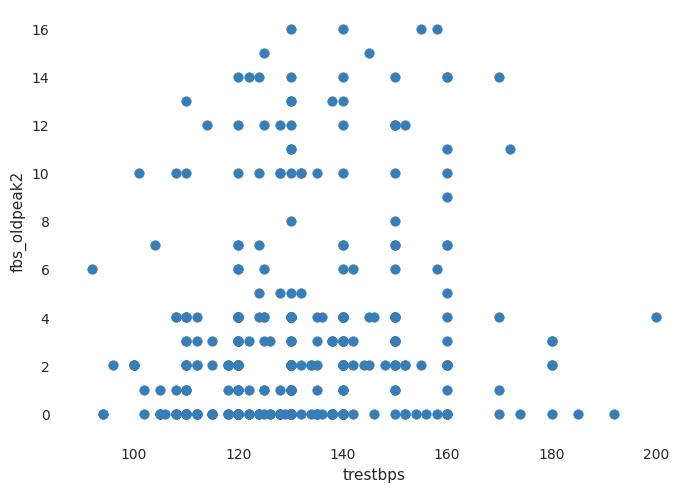

In [23]:
profile = pp.ProfileReport(df[best_features])
profile.to_widgets()